In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [43]:
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
#     print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask is not None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split is not None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# Based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [5]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return a

Churn Example

In [7]:
churnData=pd.read_csv("churn.csv")
churnData

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


In [8]:
churnData["Int'l Plan"] = churnData["Int'l Plan"]=='yes'
churnData["VMail Plan"] = churnData["VMail Plan"]=='yes'

In [9]:
cont=[ u'Account Length', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls']
cat=[u"Int'l Plan", u'VMail Plan']

Asymmetry

In [10]:
ychurn = np.where(churnData['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492

Classifiers should be about the Business End: keeping costs down

In [11]:
adminCost=3
offerCost=100
clv=1000
#customer lifetime value

In [12]:
conv=0.5
tnc = 0.
fpc = adminCost+offerCost
fnc = clv
tpc = conv*offerCost + (1. - conv)*(clv+adminCost)
tpc

551.5

In [13]:
cost=np.array([[tnc,fpc],[fnc, tpc]])
cost

array([[   0. ,  103. ],
       [1000. ,  551.5]])

In [14]:
def averageCost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

No customer churns and we send nothing

In [15]:
churntrain, churntest = train_test_split(range(churnData.shape[0]), train_size=0.6)
churnmask=np.ones(churnData.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

array([ True,  True, False, ...,  True, False,  True])

In [16]:
testchurners=churnData['Churn?'][~churnmask].values=='True.'
testchurners

array([False, False, False, ..., False, False, False])

In [17]:
testsize = churnData[~churnmask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
confusion_matrix(testchurners, ypred_dste)

array([[1119,    0],
       [ 215,    0]], dtype=int64)

In [18]:
dsteval=averageCost(testchurners, ypred_dste, cost)
dsteval

161.16941529235382

All customers churn, we send everyone

In [19]:
ypred_ste = np.ones(testsize, dtype="int")
confusion_matrix(testchurners, ypred_ste)

array([[   0, 1119],
       [   0,  215]], dtype=int64)

In [20]:
steval=averageCost(testchurners, ypred_ste, cost)
steval

175.2844827586207

Naive Bayes Classifier

In [21]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, churnData, cont+cat, 'Churn?', "True.", mask=churnmask)

using mask
############# Based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.86
[[1030   89]
 [ 101  114]]
########################################################


In [22]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1030,   89],
       [ 101,  114]], dtype=int64)

In [23]:
averageCost(ytest, clfgnb.predict(Xtest), cost)

129.7136431784108

Changing the Prediction threshold, and the ROC Curve

In [24]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [25]:
averageCost(ytest, repredict(clfgnb, 0.3, Xtest), cost)

121.78935532233884

(array([893., 131.,  49.,  30.,  28.,  24.,  20.,  12.,  38., 109.]),
 array([1.64757785e-04, 1.00148280e-01, 2.00131802e-01, 3.00115325e-01,
        4.00098847e-01, 5.00082369e-01, 6.00065891e-01, 7.00049413e-01,
        8.00032936e-01, 9.00016458e-01, 9.99999980e-01]),
 <a list of 10 Patch objects>)

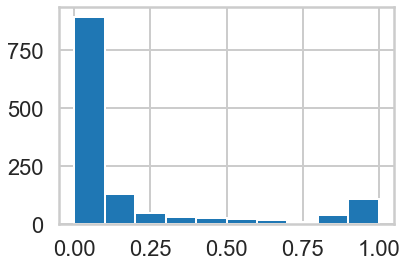

In [26]:
plt.hist(clfgnb.predict_proba(Xtest)[:,1])

The ROC Curve

In [27]:
from sklearn.metrics import roc_curve, auc

In [32]:
def makeROC(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

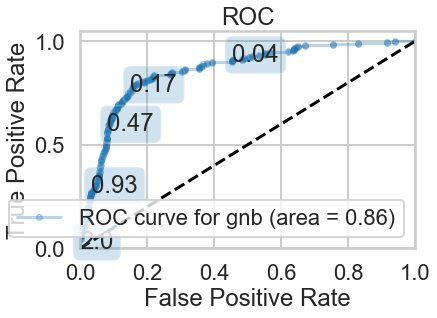

In [33]:
makeROC("gnb",clfgnb, ytest, Xtest, None, labe=50)

Classifier Comparision
Decision Trees

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [44]:
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt, {"max_depth": range(1,10,1)}, churnData, cont+cat, 'Churn?', "True.", reuse_split=reuse_split)

using reuse split
############# Based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.92
[[1081   38]
 [  63  152]]
########################################################


In [45]:
confusion_matrix(ytest,clfdt.predict(Xtest))

array([[1081,   38],
       [  63,  152]], dtype=int64)

Compare!

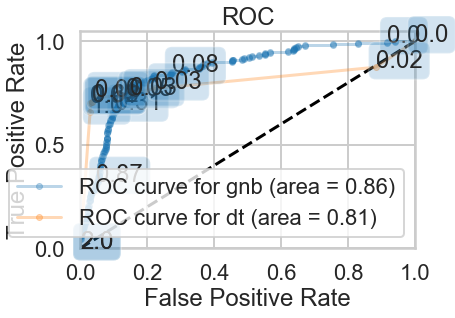

In [47]:
ax=makeROC("gnb",clfgnb, ytest, Xtest, None, labe=60)
makeROC("dt",clfdt, ytest, Xtest, ax, labe=1)

Decision Theory Math

In [49]:
print(cost)

[[   0.   103. ]
 [1000.   551.5]]


In [50]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [51]:
def c_repredict(est, c, xtest):
    r = rat(c)
    print(r)
    t=r/(1.+r)
    print("t=", t)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [52]:
averageCost(ytest, c_repredict(clfdt, cost, Xtest), cost)

0.22965440356744704
t= 0.18676337262012693


113.1544227886057

In [53]:
plt.plot(ts, [average_cost(ytest, repredict(clfdt, t, Xtest), cost) for t in ts] )

NameError: name 'ts' is not defined

Model selection from Cost and ROC

In [56]:
print(rat(cost))
slope = rat(cost)*(np.mean(ytest==0)/np.mean(ytest==1))
slope

0.22965440356744704


1.1952710585673174

In [59]:
z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    makeROC("gnb",clfgnb, ytest, Xtest, ax, labe=60)
    makeROC("dt",clfdt, ytest, Xtest, ax, labe=1)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

In [60]:
from IPython.html.widgets import interact, fixed
interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.02))

interactive(children=(FloatSlider(value=0.5, description='intercept', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.plot_line(ax, intercept)>

Cost Curves

In [61]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

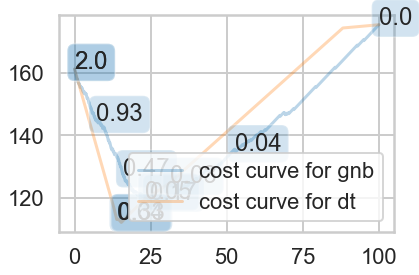

In [62]:
ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, threshold=True, labe=50);
plot_cost("dt",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=2);

In [63]:
cost

array([[   0. ,  103. ],
       [1000. ,  551.5]])